# Training XGBoost to Emulate ec-land

In this notebook we take some example Zarr data (similar to that created by this projects other functionality) and train an ML emulator of the ec-land land surface model. Here we are training on features of climatological, meteorological and previous model state values to predict the 6-hourly model state update 

In [1]:
import os
import yaml

import numpy as np
import matplotlib.pyplot as plt
import torch
import xgboost as xgb
from tqdm import tqdm
from sklearn.metrics import root_mean_squared_error

from dataset.EclandPointDataset import EcDataset

## Settings

In [2]:
data_path = "/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr"
model_path = "./test.json"
spatial_encoding = True
temporal_encoding = False

with open('config.yaml') as stream:
    try:
        CONFIG = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

## Datasets

In [3]:
def load_all_data(ds):

    x_met, x_state, y_state_inc, y_diag, x_clim, x_time = [], [], [], [], [], []
    for i in tqdm(range(len(ds)), desc="Loading dataset..."):
        x_met_i, x_state_i, y_state_inc_i, y_diag_i, x_clim_i, x_time_i = ds[i]
        x_met.append(torch.tensor(x_met_i).squeeze())
        x_state.append(torch.tensor(x_state_i).squeeze())
        y_state_inc.append(torch.tensor(y_state_inc_i).squeeze())
        y_diag.append(torch.tensor(y_diag_i).squeeze())
        x_clim.append(torch.tensor(x_clim_i).squeeze())
        x_time.append(torch.tensor(x_time_i).repeat(x_met_i.shape[1], 1))

    return torch.cat(x_met), torch.cat(x_state), torch.cat(y_state_inc), torch.cat(y_diag), torch.cat(x_clim), torch.cat(x_time)

ds_train = EcDataset(
    start_year = 2019, 
    end_year = 2019, 
    root = data_path, 
    roll_out = 1, 
    clim_features=CONFIG["clim_feats"],
    dynamic_features=CONFIG["dynamic_feats"],
    target_prog_features=CONFIG["targets_prog"],
    target_diag_features=CONFIG["targets_diag"],
    is_add_lat_lon = spatial_encoding, 
    is_norm = True, 
    dropout = 0.0
)
x_met, x_state, y_state_inc, y_diag, x_clim, x_time = load_all_data(ds_train)
X_train = torch.cat((x_met, x_state, x_time), dim=1) if temporal_encoding else torch.cat((x_met, x_state), dim=1)
y_train = torch.cat((y_state_inc, y_diag), dim=1)

ds_val = EcDataset(
    start_year = 2020, 
    end_year = 2020, 
    root = data_path, 
    roll_out = 1, 
    clim_features=CONFIG["clim_feats"],
    dynamic_features=CONFIG["dynamic_feats"],
    target_prog_features=CONFIG["targets_prog"],
    target_diag_features=CONFIG["targets_diag"],
    is_add_lat_lon = spatial_encoding, 
    is_norm = True, 
    dropout = 0.0
)
x_met, x_state, y_state_inc, y_diag, x_clim, x_time = load_all_data(ds_val)
X_val = torch.cat((x_met, x_state, x_time), dim=1) if temporal_encoding else torch.cat((x_met, x_state), dim=1)
y_val = torch.cat((y_state_inc, y_diag), dim=1)

Loading dataset...: 100%|██████████| 1463/1463 [00:51<00:00, 28.21it/s]


## Model training with XGBoost

Now we have our "features" and "targets" we can train xgboost to predict our model increments.

Fitting XGB model...
[0]	validation_0-rmse:0.14358	validation_1-rmse:0.13760
[1]	validation_0-rmse:0.08299	validation_1-rmse:0.08035
[2]	validation_0-rmse:0.05570	validation_1-rmse:0.05491
[3]	validation_0-rmse:0.04423	validation_1-rmse:0.04430
[4]	validation_0-rmse:0.03969	validation_1-rmse:0.04008
[5]	validation_0-rmse:0.03754	validation_1-rmse:0.03798
[6]	validation_0-rmse:0.03553	validation_1-rmse:0.03599
[7]	validation_0-rmse:0.03446	validation_1-rmse:0.03491
[8]	validation_0-rmse:0.03366	validation_1-rmse:0.03411
[9]	validation_0-rmse:0.03307	validation_1-rmse:0.03352
[10]	validation_0-rmse:0.03250	validation_1-rmse:0.03295
[11]	validation_0-rmse:0.03200	validation_1-rmse:0.03242
[12]	validation_0-rmse:0.03148	validation_1-rmse:0.03190
[13]	validation_0-rmse:0.03110	validation_1-rmse:0.03154
[14]	validation_0-rmse:0.03077	validation_1-rmse:0.03121
[15]	validation_0-rmse:0.03056	validation_1-rmse:0.03102
[16]	validation_0-rmse:0.03025	validation_1-rmse:0.03071
[17]	validation_0-rm

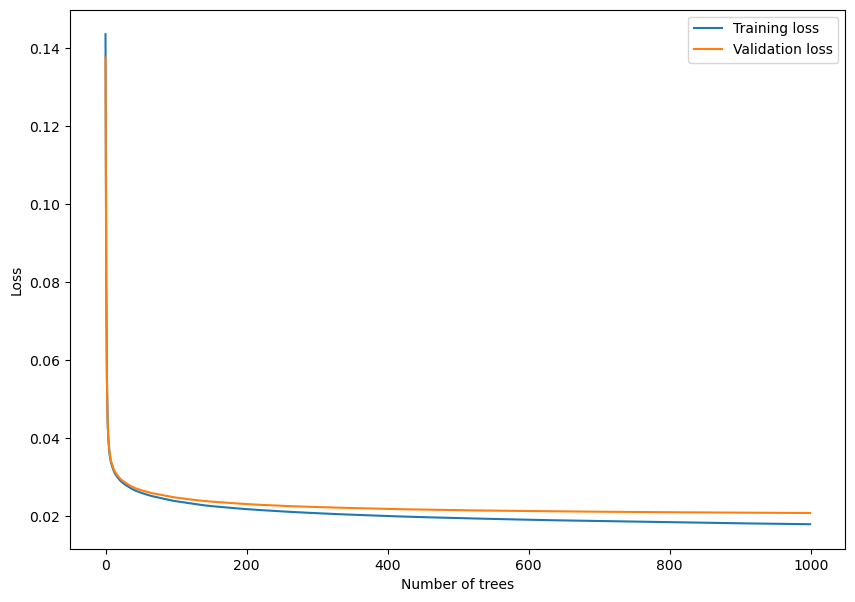

In [4]:
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.5,
    tree_method="hist",
    device="cuda",
    # device="cpu",
    early_stopping_rounds=10
)

print("Fitting XGB model...")

# At once
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
model.save_model(model_path)

results = model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

# # Incremental (doesnt work!)
# batch_size = 20000
# i = 0
# val_mse_curr = float('inf')
# while True:
#     idxs = np.random.choice(n_train, batch_size, replace=False)
#     X_batch = X_train[idxs]
#     y_batch = y_train[idxs]
#     model.fit(X_batch, y_batch, eval_set=[(X_batch, y_batch)], xgb_model=fname if i>0 else None, verbose=False)
#     model.save_model(fname)
#     y_val_pred = model.predict(X_val)
#     if i%5 == 0:
#         val_mse = mse(y_val_pred, y_val)
#         print(f"Epoch {i}: Validation MSE = {val_mse}")
#         if val_mse < val_mse_curr:
#             val_mse_curr = val_mse
#             i+=1
#         else:
#             break

print("Finished training")

del X_train, y_train

In [6]:
def rmse(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    return root_mean_squared_error(y_pred.flatten(), y_true.flatten())

y_val_pred = model.predict(X_val)
val_mse = rmse(y_val_pred, y_val)
print(f"Validation RMSE = {val_mse}")

ds_test = EcDataset(
    start_year = 2021, 
    end_year = 2022, 
    root = data_path, 
    roll_out = 1, 
    clim_features=CONFIG["clim_feats"],
    dynamic_features=CONFIG["dynamic_feats"],
    target_prog_features=CONFIG["targets_prog"],
    target_diag_features=CONFIG["targets_diag"],
    is_add_lat_lon = spatial_encoding, 
    is_norm = True, 
    dropout = 0.0
)
x_met, x_state, y_state_inc, y_diag, x_clim, x_time = load_all_data(ds_test)
X_test = torch.cat((x_met, x_state, x_time), dim=1) if temporal_encoding else torch.cat((x_met, x_state), dim=1)
y_test = torch.cat((y_state_inc, y_diag), dim=1)

y_test_pred = model.predict(X_test)
test_mse = rmse(y_test_pred, y_test)
print(f"Test RMSE = {test_mse}")

NameError: name 'X_val' is not defined